In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from scipy.sparse import csr_matrix

from sklearn.neighbors import NearestNeighbors 

In [2]:
# Importar o arquivo com os filmes
filmes = pd.read_csv('C:/Users/sicar/Documents/dados/movies_metadata.csv', low_memory = False)

# Importando o arquivo de avaliações
avaliacoes = pd.read_csv('C:/Users/sicar/Documents/dados/ratings.csv')


In [3]:
filmes.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [4]:
avaliacoes.head(3)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523


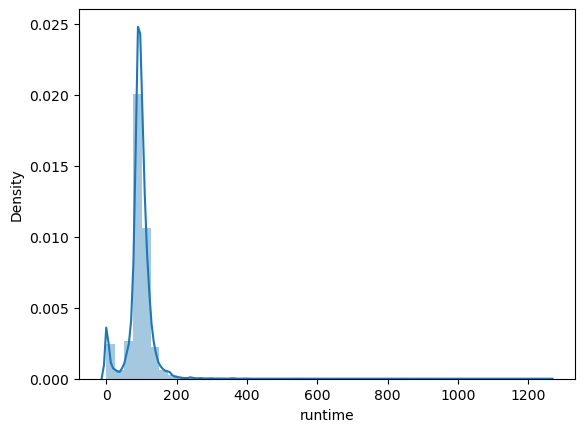

In [5]:
# visão geral da média de tempo do filme

sns.distplot( filmes['runtime'] );

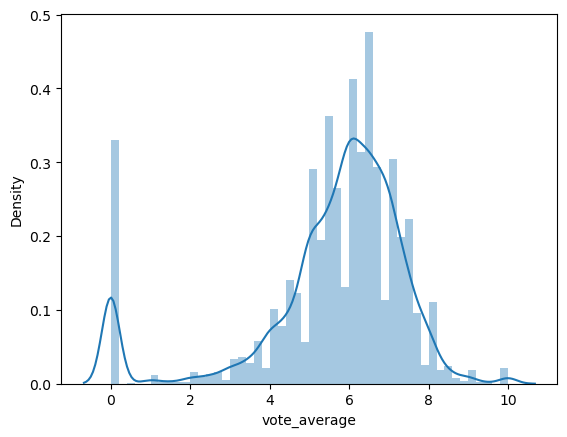

In [6]:
# visão geral da média de nota dos filmes

sns.distplot( filmes['vote_average'] );

In [7]:
# Filtrando somente as colunas necessárias
filmes = filmes [['id','original_title','original_language','vote_count']]

In [8]:
# Filtrando somente as colunas necessárias
avaliacoes = avaliacoes [['userId','movieId','rating']]

In [9]:
# Verificando se há valores nulos
filmes.isna().sum()

id                    0
original_title        0
original_language    11
vote_count            6
dtype: int64

In [10]:
# Como são poucos os valores nulos iremos remover porque não terá impacto nenhum
filmes.dropna(inplace = True)

In [11]:
# Verificando se há valores nulos
avaliacoes.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [12]:
# Vamos pegar o userId somente de usuários que fizeram mais de 500 avaliações, para um resultado mais preciso
qt_avaliacoes = avaliacoes['userId'].value_counts() > 500
y = qt_avaliacoes[qt_avaliacoes].index
y.shape

(9452,)

In [13]:
# visualizando o tamanho do dataset Avaliações
avaliacoes.shape

(26024289, 3)

In [14]:
# Pegando somente avaliacoes dos usuarios que avaliaram mais de 500 vezes
avaliacoes = avaliacoes[avaliacoes['userId'].isin(y)]

In [15]:
# visualizando o tamanho do dataset Avaliações
avaliacoes.shape

(8543119, 3)

In [16]:
# Vamos usar os filmes que possuem somente uma quantidade de avaliações superior a 500 avaliações
filmes = filmes[filmes['vote_count'] > 500]

In [17]:
# Vamos agrupar e visualizar a quantidade de filmes pela linguagem
filmes_linguagem = filmes['original_language'].value_counts()

In [18]:
# Precisamos converter a variavel ID_FILME em inteiro
filmes['id'] = filmes['id'].astype(int)

In [19]:
# Concatenando os dataframes
filmes = filmes.rename(columns={'id': 'movieId'})
avaliacoes_e_filmes = avaliacoes.merge(filmes, on = 'movieId')
avaliacoes_e_filmes.head()

,userId,movieId,rating,original_title,original_language,vote_count
0,24,25,3.0,Jarhead,en,776.0
1,120,25,4.5,Jarhead,en,776.0
2,132,25,4.0,Jarhead,en,776.0
3,150,25,3.0,Jarhead,en,776.0
4,229,25,4.0,Jarhead,en,776.0


In [20]:
# Verificando a quantidade de filmes com avaliacoes pelo tamanho do arquivo
avaliacoes_e_filmes.shape

(807744, 6)

In [21]:
# Verificando se há valores nulos
avaliacoes_e_filmes.isna().sum()

userId               0
movieId              0
rating               0
original_title       0
original_language    0
vote_count           0
dtype: int64

In [22]:
# Vamos descartar os valores duplicados, pra que o usuario não avalie o mesmo filme
avaliacoes_e_filmes.drop_duplicates(['userId','movieId'], inplace = True)

In [23]:
# Vamos excluir a variavel movieId porque não iremos utiliza-la, para deixar mais performatico
del avaliacoes_e_filmes['movieId']

In [24]:
# Agora precisamos fazer um PIVOT. O que queremos é que cada userId seja uma variavel
filmes_pivot = avaliacoes_e_filmes.pivot_table(columns = 'userId', index = 'original_title', values = 'rating')


filmes_pivot.head()

userId,24,46,120,132,150,229,231,251,332,340,...,270555,270564,270579,270631,270634,270654,270684,270734,270769,270887
original_title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"10,000 BC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 Angry Men,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN
127 Hours,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Os valores que são nulos iremos preencher com ZERO
filmes_pivot.fillna(0, inplace = True)
filmes_pivot.head()

userId,24,46,120,132,150,229,231,251,332,340,...,270555,270564,270579,270631,270634,270654,270684,270734,270769,270887
original_title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"10,000 BC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12 Angry Men,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0
127 Hours,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Vamos transformar o nosso dataset em uma matriz sparsa
filmes_sparse = csr_matrix(filmes_pivot)

In [27]:
# Criando e treinando o modelo preditivo KNN, onde o algoritmo vai ver as semelhanças dos filmes, para indicar algo parecido
modelo = NearestNeighbors(algorithm = 'brute')
modelo.fit(filmes_sparse)

NearestNeighbors(algorithm='brute')

In [28]:
# Previsões

In [29]:
# 127 Hours
distances, sugestions = modelo.kneighbors(filmes_pivot.filter(items = ['127 Hours'], axis=0).values.reshape(1, -1))

for i in range(len(sugestions)):
    print(filmes_pivot.index[sugestions[i]])  

Index(['127 Hours', 'American Hustle', 'The Expendables 2', 'Lord of War',
       'Ride Along'],
      dtype='object', name='original_title')


In [30]:
# Toy Story
distances, sugestions = modelo.kneighbors(filmes_pivot.filter(items = ['Toy Story'], axis=0).values.reshape(1, -1))

for i in range(len(sugestions)):
    print(filmes_pivot.index[sugestions[i]])  

Index(['Toy Story', 'Eragon', 'Austin Powers: International Man of Mystery',
       'Harry Potter and the Chamber of Secrets', 'Black Hawk Down'],
      dtype='object', name='original_title')


In [31]:
# 1408
distances, sugestions = modelo.kneighbors(filmes_pivot.filter(items = ['1408'], axis=0).values.reshape(1, -1))

for i in range(len(sugestions)):
    print(filmes_pivot.index[sugestions[i]]) 

Index(['1408', 'The Great Escape', 'Treasure Planet', 'Paranormal Activity 3',
       'Oldboy'],
      dtype='object', name='original_title')


In [32]:
# 2 Fast 2 Furious
distances, sugestions = modelo.kneighbors(filmes_pivot.filter(items = ['2 Fast 2 Furious'], axis=0).values.reshape(1, -1))

for i in range(len(sugestions)):
    print(filmes_pivot.index[sugestions[i]]) 

Index(['2 Fast 2 Furious', 'Filth', 'Bambi', 'The Matrix Reloaded',
       'Butch Cassidy and the Sundance Kid'],
      dtype='object', name='original_title')


In [33]:
# The Wolf of Wall Street
distances, sugestions = modelo.kneighbors(filmes_pivot.filter(items = ['The Wolf of Wall Street'], axis=0).values.reshape(1, -1))

for i in range(len(sugestions)):
    print(filmes_pivot.index[sugestions[i]]) 

Index(['The Wolf of Wall Street', 'The Expendables 2', 'Machete Kills',
       'Ride Along', 'Lord of War'],
      dtype='object', name='original_title')


In [34]:
# Por se tratar de uma recomendação não existe uma métrica exata, pois quando recomendamos algo existe a 
#possibilidade da pessoa gostar da recomendação ou não.


# Mas uma possivel forma de avaliar, seria a nota que a pessoa dar para o filme, a partir de uma recomendação,
# calcular o erro do modelo, algo como: 

#Nota: 7, Recomendação: Sim
#Nota: 9, Recomendação: Sim
        
#        com base nisso, o erro do modelo estaria em 20%